<a href="https://colab.research.google.com/github/Inglam/EECS442/blob/master/Enpei_PS6_image_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 442 PS6: Image Translation

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Enpei Zhao, zepxyz



# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [4]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101
Using the GPU!


# Problem 6.1 pix2pix
You will build pix2pix for image translation. 

In this question, you will need to:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the results during training
4. Plot the loss of generator/discriminator v.s. iteration
5. Design your own shoes

## Step 0: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs. There's nothing yo need to implement for this part, just sit back and relax while waiting for the dataset to be downloaded.

In [5]:
# Download the mini-edges2shoes dataset
!rm -r mini-edges2shoes.zip
!rm -r mini-edges2shoes
!wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
!unzip -q mini-edges2shoes.zip

rm: cannot remove 'mini-edges2shoes.zip': No such file or directory
rm: cannot remove 'mini-edges2shoes': No such file or directory
--2020-10-23 00:19:02--  http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48660290 (46M) [application/zip]
Saving to: ‘mini-edges2shoes.zip’

mini-edges2shoes.zi 100%[===================>]  46.41M  11.0MB/s    in 4.4s    

2020-10-23 00:19:07 (10.5 MB/s) - ‘mini-edges2shoes.zip’ saved [48660290/48660290]



## Step 1: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. 

In [6]:
class Edges2Shoes(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: the directory of the dataset
            split: "train" or "val"
            transform: pytorch transformations.
        """

        self.transform = transform
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # get the the file path to all train/val images
        # Hint: the function glob.glob is useful
        if (split == 'train'):
          self.files = glob.glob(root_dir + '/train'+'/*jpg')
        else:
          self.files = glob.glob(root_dir + '/val'+'/*jpg')
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img = np.asarray(img)
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== #
# Construct the dataloader
# For the train_loader, please use a batch size of 4 and set shuffle to True
# For the test_loader, please use a batch size of 5 and set shuffle to False
data_dir = 'mini-edges2shoes'

tr_dt = Edges2Shoes(data_dir, 'train', transform = transform)
train_loader = torch.utils.data.DataLoader(tr_dt, batch_size=4, shuffle=True)

te_dt = Edges2Shoes(data_dir, 'val', transform = transform)
test_loader = torch.utils.data.DataLoader(te_dt, batch_size=5, shuffle=False)

# ============== END OF CODE ================= # 
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1000, number of testing images 100


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


250
20
torch.Size([5, 3, 256, 256])


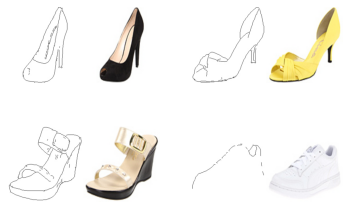

In [7]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
    example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    example = std * example + mean
    axes[i].imshow(example)
    axes[i].axis('off')
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

In [8]:
def normal_init(m, mean, std):
    """
    Helper function. Initialize model parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [9]:
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
		#++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        self.cv1 = nn.Conv2d(3, 64, (4,4), (2,2), (1,1))
        self.cv2 = nn.Conv2d(64, 128, (4,4), (2,2), (1,1))
        self.cv3 = nn.Conv2d(128, 256, (4,4), (2,2), (1,1))
        self.cv4 = nn.Conv2d(256, 512, (4,4), (2,2), (1,1))
        self.cv5 = nn.Conv2d(512, 512, (4,4), (2,2), (1,1))
        self.cv6 = nn.Conv2d(512, 512, (4,4), (2,2), (1,1))
        self.cv7 = nn.Conv2d(512, 512, (4,4), (2,2), (1,1))
        self.cv8 = nn.Conv2d(512, 512, (4,4), (2,2), (1,1))
        self.bn2 = nn.BatchNorm2d(128, 1e-05, 0.1, True, True)
        self.bn3 = nn.BatchNorm2d(256, 1e-05, 0.1, True, True)
        self.bn4 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.bn5 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.bn6 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.bn7 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)

        self.ctv1 = nn.ConvTranspose2d(512, 512, (4,4), (2,2), (1,1))  # note second parameter is output
        self.btn1 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.ctv2 = nn.ConvTranspose2d(1024, 512, (4,4), (2,2), (1,1))
        self.btn2 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.ctv3 = nn.ConvTranspose2d(1024, 512, (4,4), (2,2), (1,1))
        self.btn3 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.ctv4 = nn.ConvTranspose2d(1024, 512, (4,4), (2,2), (1,1))
        self.btn4 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.ctv5 = nn.ConvTranspose2d(1024, 256, (4,4), (2,2), (1,1))
        self.btn5 = nn.BatchNorm2d(256, 1e-05, 0.1, True, True)
        self.ctv6 = nn.ConvTranspose2d(512, 128, (4,4), (2,2), (1,1))
        self.btn6 = nn.BatchNorm2d(128, 1e-05, 0.1, True, True)
        self.ctv7 = nn.ConvTranspose2d(256, 64, (4,4), (2,2), (1,1))
        self.btn7 = nn.BatchNorm2d(64, 1e-05, 0.1, True, True)
        self.ctv8 = nn.ConvTranspose2d(128, 3, (4,4), (2,2), (1,1))

		# ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
		#++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #

        # encoder
        x1 = torch.nn.functional.leaky_relu(self.cv1(input),0.2) 
        x2 = torch.nn.functional.leaky_relu(self.bn2(self.cv2(x1)),0.2)
        x3 = torch.nn.functional.leaky_relu(self.bn3(self.cv3(x2)),0.2) 
        x4 = torch.nn.functional.leaky_relu(self.bn4(self.cv4(x3)),0.2) 
        x5 = torch.nn.functional.leaky_relu(self.bn5(self.cv5(x4)),0.2) 
        x6 = torch.nn.functional.leaky_relu(self.bn6(self.cv6(x5)),0.2)
        x7 = torch.nn.functional.leaky_relu(self.bn7(self.cv7(x6)),0.2) 
        x8 = torch.nn.functional.leaky_relu(self.cv8(x7),0.2) 

        # decoder
        #c1 = torch.cat((x8,x7),1)
        y1 = torch.nn.functional.relu(self.btn1(self.ctv1(x8)))
        c2 = torch.cat((x7,y1),1)
        y2 = torch.nn.functional.relu(self.btn2(self.ctv2(c2)))
        c3 = torch.cat((x6,y2),1)
        y3 = torch.nn.functional.relu(self.btn3(self.ctv3(c3)))
        c4 = torch.cat((x5,y3),1)
        y4 = torch.nn.functional.relu(self.btn4(self.ctv4(c4)))
        c5 = torch.cat((x4,y4),1)
        y5 = torch.nn.functional.relu(self.btn5(self.ctv5(c5)))
        c6 = torch.cat((x3,y5),1)
        y6 = torch.nn.functional.relu(self.btn6(self.ctv6(c6)))
        c7 = torch.cat((x2,y6),1)
        y7 = torch.nn.functional.relu(self.btn7(self.ctv7(c7)))
        c8 = torch.cat((x1,y7),1)
        y8 = torch.nn.functional.relu(self.ctv8(c8))
        o = torch.tanh(y8)

		# ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        return o

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
		#++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        self.cv1 = nn.Conv2d(6, 64, (4,4), (2,2), (1,1))
        self.cv2 = nn.Conv2d(64, 128, (4,4), (2,2), (1,1))
        self.cv3 = nn.Conv2d(128, 256, (4,4), (2,2), (1,1))
        self.cv4 = nn.Conv2d(256, 512, (4,4), (1,1), (1,1))

        self.bn2 = nn.BatchNorm2d(128, 1e-05, 0.1, True, True)
        self.bn3 = nn.BatchNorm2d(256, 1e-05, 0.1, True, True)
        self.bn4 = nn.BatchNorm2d(512, 1e-05, 0.1, True, True)
        self.ctv1 = nn.Conv2d(512, 1, (4,4), (1,1), (1,1))
		# ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
	    #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        x1 = torch.nn.functional.leaky_relu(self.cv1(input),0.2) 
        x2 = torch.nn.functional.leaky_relu(self.bn2(self.cv2(x1)),0.2)
        x3 = torch.nn.functional.leaky_relu(self.bn3(self.cv3(x2)),0.2) 
        x4 = torch.nn.functional.leaky_relu(self.bn4(self.cv4(x3)),0.2)
        x5 = self.ctv1(x4)
        x = torch.sigmoid(x5)
		# ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        return x

In [10]:

# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

**Make sure your model architecturees summary from the above cell match with the given architecture below.**

### generator architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 512, 1, 1]       4,194,816
    ConvTranspose2d-15            [-1, 512, 2, 2]       4,194,816
        BatchNorm2d-16            [-1, 512, 2, 2]           1,024
    ConvTranspose2d-17            [-1, 512, 4, 4]       8,389,120
        BatchNorm2d-18            [-1, 512, 4, 4]           1,024
    ConvTranspose2d-19            [-1, 512, 8, 8]       8,389,120
        BatchNorm2d-20            [-1, 512, 8, 8]           1,024
    ConvTranspose2d-21          [-1, 512, 16, 16]       8,389,120
        BatchNorm2d-22          [-1, 512, 16, 16]           1,024
    ConvTranspose2d-23          [-1, 256, 32, 32]       4,194,560
        BatchNorm2d-24          [-1, 256, 32, 32]             512
    ConvTranspose2d-25          [-1, 128, 64, 64]       1,048,704
        BatchNorm2d-26          [-1, 128, 64, 64]             256
    ConvTranspose2d-27         [-1, 64, 128, 128]         262,208
        BatchNorm2d-28         [-1, 64, 128, 128]             128
    ConvTranspose2d-29          [-1, 3, 256, 256]           6,147
----------------------------------------------------------------
    Total params: 54,419,459
    Trainable params: 54,419,459
    Non-trainable params: 0
----------------------------------------------------------------


### discriminator architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 1, 30, 30]           8,193
----------------------------------------------------------------
    Total params: 2,769,601
    Trainable params: 2,769,601
    Non-trainable params: 0
----------------------------------------------------------------


## Step 3: Train

In this section, complete the function train. 
Then train two model: one with only L1 loss, the other with c=100.



In [11]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 2].get_xaxis().set_visible(False)
        ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
        ax[i, 2].cla()
        ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [12]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
    hist_D_losses = []
    hist_G_losses = []
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # Adam optimizers for both the generator and 
    # the discriminator
    G_optimizer = optim.Adam(G.parameters(), 2e-4, (0.5,0.999))
    D_optimizer = optim.Adam(D.parameters(), 2e-4, (0.5,0.999))
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #

    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0
        for x_ in train_loader:

            y_ = x_[:, :, :, img_size:]
            x_ = x_[:, :, :, 0:img_size]
            
            x_, y_ = x_.cuda(), y_.cuda()
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 
            #Train the discriminator

            D.zero_grad()

            D_fake_input = torch.cat([x_, G(x_)], 1)
            D_fake_result = D(D_fake_input).squeeze()
            D_fake_loss = BCE_loss(D_fake_result, torch.zeros(D_fake_result.size()).cuda())

            D_real_input = torch.cat([x_, y_], 1)
            D_real_result = D(D_real_input).squeeze()
            D_real_loss = BCE_loss(D_real_result, torch.ones(D_real_result.size()).cuda())
            
            loss_output = (D_real_loss + D_fake_loss) / 2;
            loss_output.backward()

            D_optimizer.step()
            loss_D = loss_output.item()

            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 

            # Train the generator
            G.zero_grad()

            G_result = G(x_)
            D_input = torch.cat([x_, G_result], 1)
            D_result = D(D_input).squeeze()

            if only_L1:
                G_train_loss = L1_loss(G_result, y_)
            else:
                G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
            
            G_train_loss.backward()
            G_optimizer.step()
            loss_G = G_train_loss.detach().item()

            D_losses.append(loss_D)
            hist_D_losses.append(loss_D)
            G_losses.append(loss_G)
            hist_G_losses.append(loss_G)
            num_iter += 1

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        if epoch == 0 or (epoch + 1) % 5 == 0:
            with torch.no_grad():
                show_result(G, fixed_x_, fixed_y_, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses

In this part, train your model with c=100 with at leat 20 epoch.

In [13]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (cv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (cv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (cv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (cv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ctv1): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

training start!
Start training epoch 1
[1/20] - using time: 62.89 seconds
loss of discriminator D: 0.161
loss of generator G: 30.851


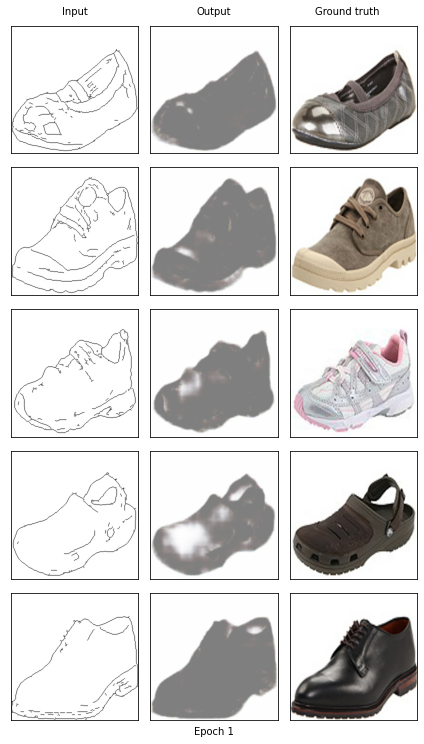

Start training epoch 2
[2/20] - using time: 66.91 seconds
loss of discriminator D: 0.003
loss of generator G: 27.948
Start training epoch 3
[3/20] - using time: 66.96 seconds
loss of discriminator D: 0.002
loss of generator G: 28.603
Start training epoch 4
[4/20] - using time: 67.06 seconds
loss of discriminator D: 0.176
loss of generator G: 26.734
Start training epoch 5
[5/20] - using time: 67.12 seconds
loss of discriminator D: 0.034
loss of generator G: 26.883


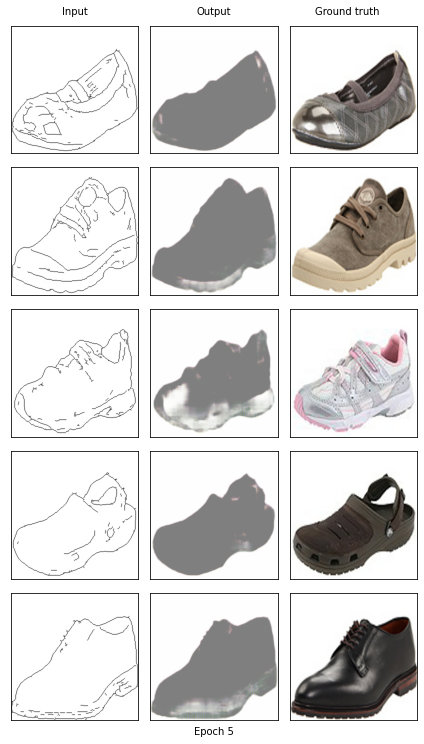

Start training epoch 6
[6/20] - using time: 68.11 seconds
loss of discriminator D: 0.004
loss of generator G: 27.628
Start training epoch 7
[7/20] - using time: 67.92 seconds
loss of discriminator D: 0.001
loss of generator G: 27.937
Start training epoch 8
[8/20] - using time: 67.95 seconds
loss of discriminator D: 0.001
loss of generator G: 28.170
Start training epoch 9
[9/20] - using time: 67.62 seconds
loss of discriminator D: 0.001
loss of generator G: 28.164
Start training epoch 10
[10/20] - using time: 67.53 seconds
loss of discriminator D: 0.000
loss of generator G: 28.128


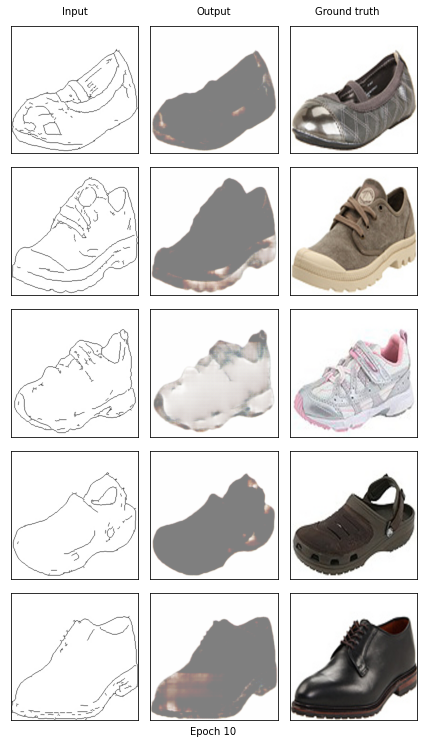

Start training epoch 11
[11/20] - using time: 67.12 seconds
loss of discriminator D: 0.000
loss of generator G: 28.033
Start training epoch 12
[12/20] - using time: 67.16 seconds
loss of discriminator D: 0.000
loss of generator G: 28.041
Start training epoch 13
[13/20] - using time: 67.08 seconds
loss of discriminator D: 0.000
loss of generator G: 27.780
Start training epoch 14
[14/20] - using time: 67.11 seconds
loss of discriminator D: 0.000
loss of generator G: 28.007
Start training epoch 15
[15/20] - using time: 67.06 seconds
loss of discriminator D: 0.000
loss of generator G: 27.959


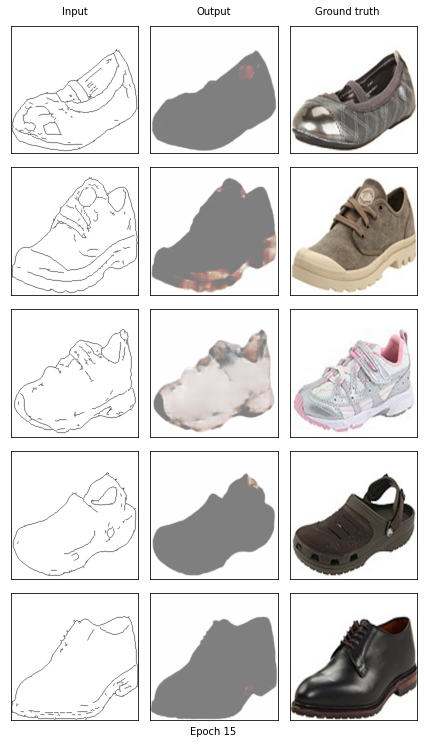

Start training epoch 16
[16/20] - using time: 67.70 seconds
loss of discriminator D: 0.000
loss of generator G: 28.000
Start training epoch 17
[17/20] - using time: 67.57 seconds
loss of discriminator D: 0.000
loss of generator G: 28.014
Start training epoch 18
[18/20] - using time: 67.37 seconds
loss of discriminator D: 0.206
loss of generator G: 24.848
Start training epoch 19
[19/20] - using time: 67.49 seconds
loss of discriminator D: 0.001
loss of generator G: 26.767
Start training epoch 20
[20/20] - using time: 67.27 seconds
loss of discriminator D: 0.000
loss of generator G: 27.002


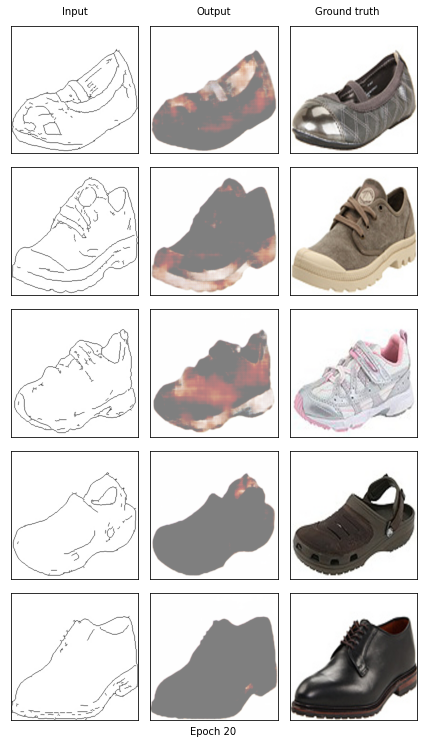

In [14]:
#training
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [15]:
!mkdir models
torch.save(G_100.state_dict(), './models/G_100.pth')
torch.save(D_100.state_dict(), './models/D_100.pth')

In this part, train your model with only L1 loss with at leat 10 epoch.

training start!
Start training epoch 1
[1/10] - using time: 62.08 seconds
loss of discriminator D: 0.121
loss of generator G: 0.274


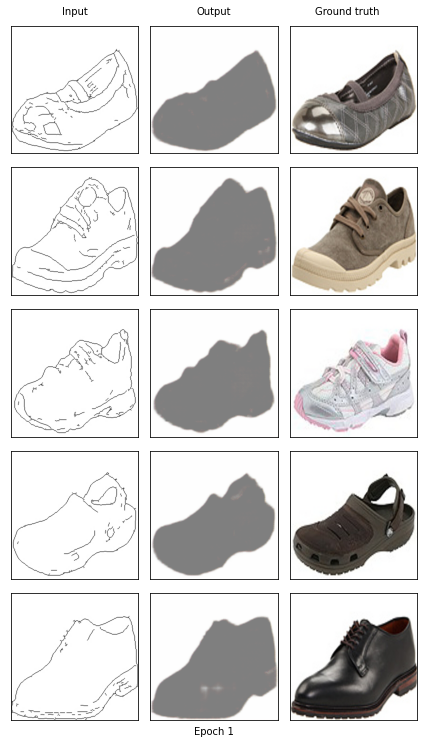

Start training epoch 2
[2/10] - using time: 62.20 seconds
loss of discriminator D: 0.113
loss of generator G: 0.220
Start training epoch 3
[3/10] - using time: 62.18 seconds
loss of discriminator D: 0.002
loss of generator G: 0.219
Start training epoch 4
[4/10] - using time: 62.01 seconds
loss of discriminator D: 0.001
loss of generator G: 0.216
Start training epoch 5
[5/10] - using time: 61.61 seconds
loss of discriminator D: 0.001
loss of generator G: 0.215


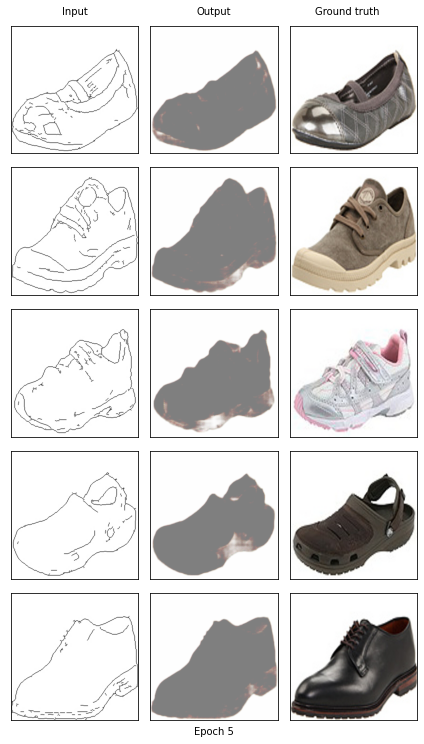

Start training epoch 6
[6/10] - using time: 61.92 seconds
loss of discriminator D: 0.000
loss of generator G: 0.213
Start training epoch 7
[7/10] - using time: 62.11 seconds
loss of discriminator D: 0.000
loss of generator G: 0.212
Start training epoch 8
[8/10] - using time: 61.90 seconds
loss of discriminator D: 0.000
loss of generator G: 0.211
Start training epoch 9
[9/10] - using time: 61.88 seconds
loss of discriminator D: 0.000
loss of generator G: 0.209
Start training epoch 10
[10/10] - using time: 61.90 seconds
loss of discriminator D: 0.000
loss of generator G: 0.208


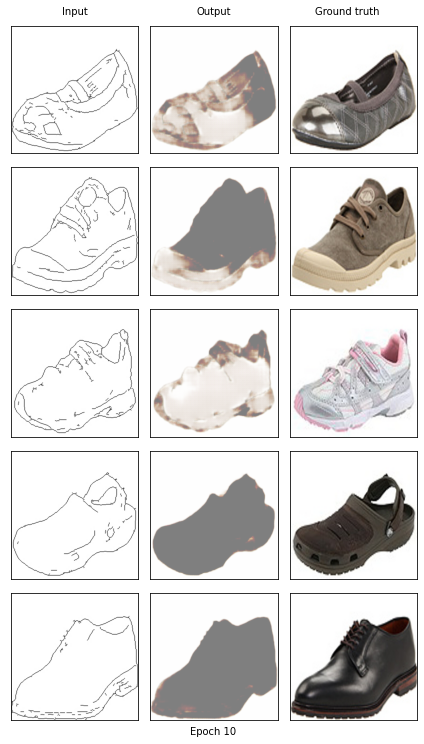

In [16]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

#training
# TODO: change_num_epochs if you want
hist_D_L1_losses, hist_G_L1_losses = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

### Please comment on the quality of generated images from L1+cGAN and L1 only:

Images obtained from L1 + cGAN is much more accurate than images obtained from L1 only.

In [17]:
torch.save(G_L1.state_dict(), './models/G_L1.pth')
torch.save(D_L1.state_dict(), './models/D_L1.pth')

In [18]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/G_100.pth (deflated 7%)
  adding: models/D_100.pth (deflated 7%)
  adding: models/D_L1.pth (deflated 7%)
  adding: models/G_L1.pth (deflated 7%)


## Step 4: Viulization



In this section, plot the G/D loss history v.s. Iteration of models with c=100 seperate plots.

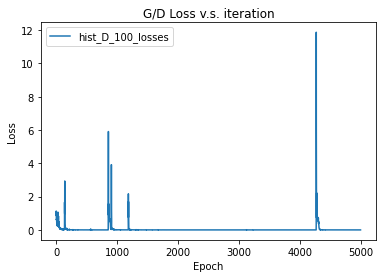

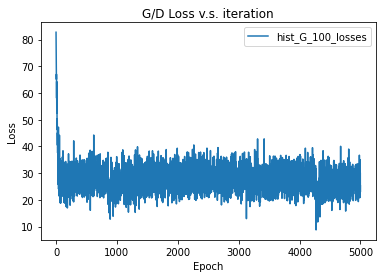

In [19]:
# plot the G/D loss history v.s. Iteration
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 
x = np.arange(5000)
plt.figure()
plt.plot(x, hist_D_100_losses)
plt.legend(['hist_D_100_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('G/D Loss v.s. iteration')
plt.show()

x = np.arange(5000)
plt.figure()
plt.plot(x, hist_G_100_losses)
plt.legend(['hist_G_100_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('G/D Loss v.s. iteration')
plt.show()

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 



In this section, plot the G/D loss history v.s. Iteration of model with only L1 loss in seperate plots.

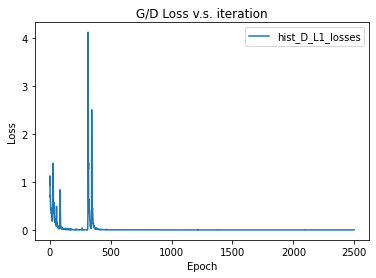

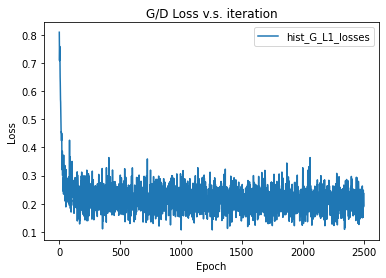

In [20]:
# plot the G/D loss history v.s. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== #
x = np.arange(2500)
plt.figure()
plt.plot(x, hist_D_L1_losses)
plt.legend(['hist_D_L1_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('G/D Loss v.s. iteration')
plt.show()

x = np.arange(2500)
plt.figure()
plt.plot(x, hist_G_L1_losses)
plt.legend(['hist_G_L1_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('G/D Loss v.s. iteration')
plt.show()
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 

## Step 5: Design Your Shoes

Now you can sketch your dream shoes and let the trained model generate them for you! Try to be creative!

In [21]:
# Build a panel that allows sketching in Colab
# Source: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
    print('Please sketch below.')
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return len(binary)

!mkdir mini-edges2shoes/custom
!apt-get --quiet install imagemagick

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsf

In [22]:
# Press left mouse button and drag your mouse to draw a sketch.
# Then click Finish.
draw(w=256, h=256)
!convert drawing.png drawing.jpg

# save the drawing to dataset folder as a jpg image
img = np.asarray(Image.open('drawing.png'))
img = 255 - img
image.imsave('./mini-edges2shoes/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))

custom_dt = Edges2Shoes('./mini-edges2shoes', 'custom', transform)
custom_loader = DataLoader(custom_dt, batch_size=1, shuffle=False)

Please sketch below.


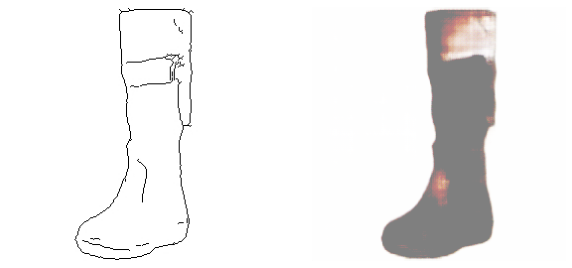

In [23]:
# Optional: for loading saved generator
G_100 = generator().cuda()
G_100.load_state_dict(torch.load('./models/G_100.pth'))
G_100.eval()

# process the sketch
for x_ in custom_loader:
    x_ = x_.cuda()[:,:,:,:img_size]
    y_ = G_100(x_)

# visualize the image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
img_ = process_image(y_[0])
img = process_image(x_[0])
axis[0].imshow(img)
axis[0].axis('off')
axis[1].imshow(img_)
axis[1].axis('off')
plt.show()

# Problem 6.2 calculating receptive field size

Please write down the perceptive field size in in this text cell. 

__Please directly replace $?$ with you answer in the expression below.__

$$ Input $$
$$ \downarrow $$
$$ C64 (\text{receptive field size} = 4) $$
$$ \downarrow $$
$$ C128(\text{receptive field size}=10) $$
$$ \downarrow $$
$$ C256(\text{receptive field size}=22) $$
$$ \downarrow $$
$$ C512(\text{receptive field size}=46) $$

In [ ]:
# generate pdf
%%capture
!git clone https://gist.github.com/bc5f1add34fef7c7f9fb83d3783311e2.git
!cp bc5f1add34fef7c7f9fb83d3783311e2/colab_pdf.py colab_pdf.py
from colab_pdf import colab_pdf
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
colab_pdf('Enpei_PS6_image_translation.ipynb')